# Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Library Definition

In [ ]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score

from matplotlib import pyplot as plt
from lightgbm import LGBMClassifier

# Preprocess

In [ ]:
X_model_file_path = "/content/drive/Shareddrives/Intro-data-science/data/X_model.csv"
Y_model_file_path = "/content/drive/Shareddrives/Intro-data-science/data/Y_model.csv"
X_test_file_path = "/content/drive/Shareddrives/Intro-data-science/data/X_exam.csv"

X_model = pd.read_csv(X_model_file_path)
Y_model = pd.read_csv(Y_model_file_path)
X_test = pd.read_csv(X_test_file_path)

In [ ]:
X_model_test = pd.concat([X_model, X_test], axis=0)
X_model_test.head()

,gender,age_code,region_code,c20220101,c20220102,c20220103,c20220104,c20220105,c20220106,c20220107,...,t20220817,t20220818,t20220819,t20220820,t20220821,t20220822,t20220823,t20220824,t20220825,t20220826
0,1,13,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1,5,1,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,6,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
Y_model.head()

,business
0,0
1,0
2,0
3,0
4,0


## Missing Value Handling

In [ ]:
X_model_test.info(verbose = True, null_counts = True)

<ipython-input-25-0312d011135d>:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  X_model_test.info(verbose = True, null_counts = True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 199999
Data columns (total 717 columns):
 #    Column       Non-Null Count    Dtype  
---   ------       --------------    -----  
 0    gender       1000000 non-null  int64  
 1    age_code     1000000 non-null  int64  
 2    region_code  1000000 non-null  int64  
 3    c20220101    118965 non-null   float64
 4    c20220102    114903 non-null   float64
 5    c20220103    183263 non-null   float64
 6    c20220104    164356 non-null   float64
 7    c20220105    180875 non-null   float64
 8    c20220106    158136 non-null   float64
 9    c20220107    154618 non-null   float64
 10   c20220108    111350 non-null   float64
 11   c20220109    109741 non-null   float64
 12   c20220110    195018 non-null   float64
 13   c20220111    167618 non-null   float64
 14   c20220112    162418 non-null   float64
 15   c20220113    159433 non-null   float64
 16   c20220114    166556 non-null   float64
 17   c20220115    117958 non-nu

In [ ]:
X_model_test = X_model_test.fillna(0)

assert(X_model_test.isnull().sum().sum() == 0)

## Scaling

In [ ]:
columns_scaled = [c for c in X_model_test.columns if c not in ['gender', 'age_code', 'region_code']]
 
scaler = MinMaxScaler()
scaler.fit(X_model_test[columns_scaled])

X_model_test[columns_scaled] = scaler.transform(X_model_test[columns_scaled])
X_model_test.head()

,gender,age_code,region_code,c20220101,c20220102,c20220103,c20220104,c20220105,c20220106,c20220107,...,t20220817,t20220818,t20220819,t20220820,t20220821,t20220822,t20220823,t20220824,t20220825,t20220826
0,1,13,7,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032258
1,1,5,1,0.0,0.0,0.0,0.0,0.019608,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,2,6,2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,2,1,1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,2,5,1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


## Imputation

In [ ]:
#gender code string encoding
X_model_test['gender'] = X_model_test['gender']-1
X_model_test['gender']

0         0
1         0
2         1
3         1
4         1
         ..
199995    1
199996    0
199997    0
199998    0
199999    1
Name: gender, Length: 1000000, dtype: int64

In [ ]:
X_model_test = pd.get_dummies(X_model_test, columns = ['age_code', 'region_code'])
X_model_test.head()

,gender,c20220101,c20220102,c20220103,c20220104,c20220105,c20220106,c20220107,c20220108,c20220109,...,region_code_9,region_code_10,region_code_11,region_code_12,region_code_13,region_code_14,region_code_15,region_code_16,region_code_17,region_code_18
0,0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.0,0.0,0.0,0.0,0.019608,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


# Hyperparameter Tunning : PCA

In [ ]:
def apply_pca(n_comp, X_model_test):
  pca = PCA(n_comp)
  X_model_test_pca = pd.DataFrame(pca.fit_transform(X_model_test), columns = [f"feature_{i}" for i in range(1, n_comp+1)])
  
  return X_model_test_pca

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

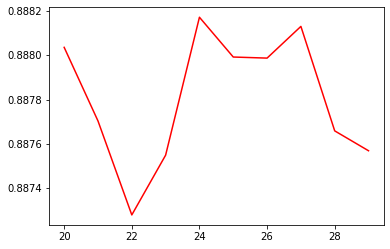

In [ ]:
min_n_comp = 20
max_n_comp = 30

max_cv_valid_score = 0
cv_valid_scores = []

range_age_code = 14
range_region_code = 18
X_model_length = X_model.shape[0]

for n_comp in range(min_n_comp, max_n_comp):

  X_model_test_temp = X_model_test.copy()

  X_model_test_gender = X_model_test_temp.iloc[:, 0].reset_index(drop = True)
  X_model_test_age_region = X_model_test_temp.iloc[:, -(range_age_code + range_region_code):].reset_index(drop = True)
  X_model_test_pca = apply_pca(n_comp, X_model_test_temp.iloc[:, 1:-(range_age_code + range_region_code)]).reset_index(drop = True)

  X_model_test_temp = pd.concat([X_model_test_gender, X_model_test_age_region, X_model_test_pca], axis = 1)

  model = LGBMClassifier(n_estimators = 100)

  X_model_temp = X_model_test_temp.iloc[:X_model_length, :]
  cv_valid_score = cross_val_score(model, X_model_temp, Y_model, scoring = 'roc_auc', cv = 5).mean()
  cv_valid_scores.append(cv_valid_score)

  if max_cv_valid_score < cv_valid_score:
    max_cv_valid_score = cv_valid_score
    n_comp_best = n_comp
    X_model_test_best = X_model_test_temp

X_model_test = X_model_test_best

plt.plot(range(min_n_comp, max_n_comp), cv_valid_scores, 'r')
plt.show()

In [ ]:
print(f"max cv_score: {max_cv_valid_score}")
print(f"best n_comp: {n_comp_best}")

max cv_score: 0.8881719112356066
best n_comp: 24


In [ ]:
X_model = X_model_test.iloc[:X_model_length, :]
X_test = X_model_test.iloc[X_model_length:, :]

In [ ]:
X_model.to_csv("/content/drive/Shareddrives/Intro-data-science/data/X_model_preprocess_pca.csv")

In [ ]:
X_test.to_csv("/content/drive/Shareddrives/Intro-data-science/data/X_test_preprocess_pca.csv")